In [342]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)

covid19_cases = pd.read_csv('Datasets\COVID-19 Cases.csv', index_col='Date', parse_dates=True)
population_density = pd.read_csv('Datasets\API_EN.POP.DNST_DS2_en_csv_v2_988966.csv', index_col='Country Code')
total_population = pd.read_csv('Datasets\API_SP.POP.TOTL_DS2_en_csv_v2_988606.csv', index_col='Country Code')

#extract relevant columns
covid19_cases = covid19_cases[['Case_Type', 'People_Total_Tested_Count',  'Cases',  'Difference','Country_Region', 'Province_State', 'Admin2', 'iso3', 'Difference']]
#merge with population density data
covid19_cases = covid19_cases.merge(population_density[['2018']], left_on='iso3', right_index=True)
#rename the column
covid19_cases = covid19_cases.rename(columns={'2018':'Population_density-sqKm'})

confirmed = covid19_cases[covid19_cases['Case_Type']=='Confirmed']
deaths = covid19_cases[covid19_cases['Case_Type']=='Deaths']

In [343]:
#group by country by date
confirmed_per_day_per_country = confirmed.groupby(['iso3', confirmed.index])['Difference']
#drop redundant index level
confirmed_per_day_per_country = confirmed_per_day_per_country.sum().droplevel(level=2)
#drop duplicates
confirmed_per_day_per_country = confirmed_per_day_per_country.drop_duplicates()
confirmed_per_day_per_country = confirmed_per_day_per_country.groupby(level=0).mean()

#group by country by date
deaths_per_day_per_country = deaths.groupby(['iso3', deaths.index])['Difference']
#drop redundant index level
deaths_per_day_per_country = deaths_per_day_per_country.sum().droplevel(level=2)
#drop duplicates
deaths_per_day_per_country = deaths_per_day_per_country.drop_duplicates()
#make a copy of the dataframe for later use in another section
deaths_per_day_per_country_cpy = deaths_per_day_per_country
#group the data at the outermost index level, ie. the countries name in iso3 format
deaths_per_day_per_country = deaths_per_day_per_country.groupby(level=0).mean()

#get latest data for both confirmed and death reports
confirmed_latest = confirmed[covid19_cases.index.max().isoformat()]
deaths_latest = deaths[covid19_cases.index.max().isoformat()]

#group the latest data for each country by country code and aggregate the result
cases_per_country = confirmed_latest.groupby('iso3')['Cases'].sum()
deaths_per_country = deaths_latest.groupby('iso3')['Cases'].sum()

#Compute daily mean of new cases and deaths
mean_new_cases_per_country = confirmed.groupby('iso3')['Difference'].mean()
mean_deaths_per_country = deaths.groupby('iso3')['Difference'].mean()

#drop duplicates
mean_new_cases_per_country.drop_duplicates(inplace=True)
mean_deaths_per_country.drop_duplicates(inplace=True)

#change multilevel index to single index
mean_new_cases_per_country = mean_new_cases_per_country.droplevel(level=1)
mean_deaths_per_country = mean_deaths_per_country.droplevel(level=1)

In [344]:
#reindexing for merging and concating with other data based on country code
covid19_cases.set_index(covid19_cases['iso3'], inplace=True)

#merge the population density data with new cases and mortality data
popl_cases = pd.concat([ covid19_cases[['Population_density-sqKm']].drop_duplicates() , cases_per_country, confirmed_per_day_per_country, deaths_per_country, deaths_per_day_per_country] , ignore_index=True, axis=1, sort=False)
#merge the total population data
popl_cases = popl_cases.merge(total_population['2018'], left_index=True, right_index=True)

In [345]:
#rename columns
popl_cases = popl_cases.rename(columns={0:'Population-sqkm', 1:'Total_cases', 2:'Mean_new_per_country', 3:'Total_deaths', 4:'Mean_deaths_per_country','2018':'Total_population'})
#drop NaN data
popl_cases.dropna(inplace=True)
popl_cases['Perc_cases_to_popl'] = (popl_cases['Total_cases'] / popl_cases['Total_population']) * 100

#print(popl_cases.sort_values('Population-sqkm'))
popl_cases = popl_cases[popl_cases['Population-sqkm'] < 750][popl_cases['Perc_cases_to_popl'] < 0.5]


C:\Users\Hope\Miniconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


# 1.	Is the population density related to the overall confirmed cases?


Correlation between Population density and mean of new cases reported daily: 
Pearson coefficient = 0.14854635801935032


Text(0, 0.5, 'Ration of total cases to population')

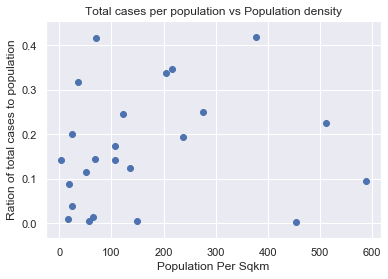

In [346]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x,y)

    # Return entry [0,1]
    return corr_mat[0,1]

#Compute the pearson coefficient for the pair undertaken
pc = pearson_r(popl_cases['Population-sqkm'], popl_cases['Perc_cases_to_popl'])
print('\nCorrelation between Population density and mean of new cases reported daily: \nPearson coefficient = {}'.format(pc))

#Format and Plot the data in scatter plot
fig, ax = plt.subplots(1, 1)

ax.scatter(popl_cases['Population-sqkm'], popl_cases['Perc_cases_to_popl'])
ax.set_title("Total cases per population vs Population density")
ax.set_xlabel('Population Per Sqkm')
ax.set_ylabel('Ration of total cases to population')

# 2. How related are New cases and deaths to Population Density?


Correlation between Population density and mean of new cases reported daily: 
Pearson coefficient = -0.15031348998792302

Correlation between Population density and mean of deaths reported daily: 
Pearson coefficient = -0.08609673524017475


Text(0, 0.5, 'Mean of Daily Deaths')

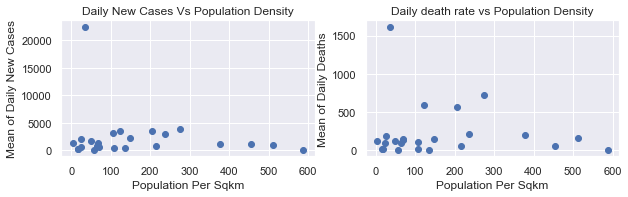

In [347]:
#Compute the pearson coefficient for the pair undertaken

pc2 = pearson_r(popl_cases['Population-sqkm'], popl_cases['Mean_new_per_country'])
pc3 = pearson_r(popl_cases['Population-sqkm'], popl_cases['Mean_deaths_per_country'])

print('\nCorrelation between Population density and mean of new cases reported daily: \nPearson coefficient = {}'.format(pc2))
print('\nCorrelation between Population density and mean of deaths reported daily: \nPearson coefficient = {}'.format(pc3))

#Format and plot the result in scatter plot
fig, ax = plt.subplots(1,2)
fig.set_figheight(2.5)
fig.set_figwidth(10)
ax[0].scatter(popl_cases['Population-sqkm'], popl_cases['Mean_new_per_country'])
ax[0].set_title("Daily New Cases Vs Population Density")
ax[0].set_xlabel('Population Per Sqkm')
ax[0].set_ylabel('Mean of Daily New Cases')

ax[1].scatter(popl_cases['Population-sqkm'], popl_cases['Mean_deaths_per_country'])
ax[1].set_title("Daily death rate vs Population Density")
ax[1].set_xlabel('Population Per Sqkm')
ax[1].set_ylabel('Mean of Daily Deaths')

# 3.	Does increasing test helping to rectify the death rate?

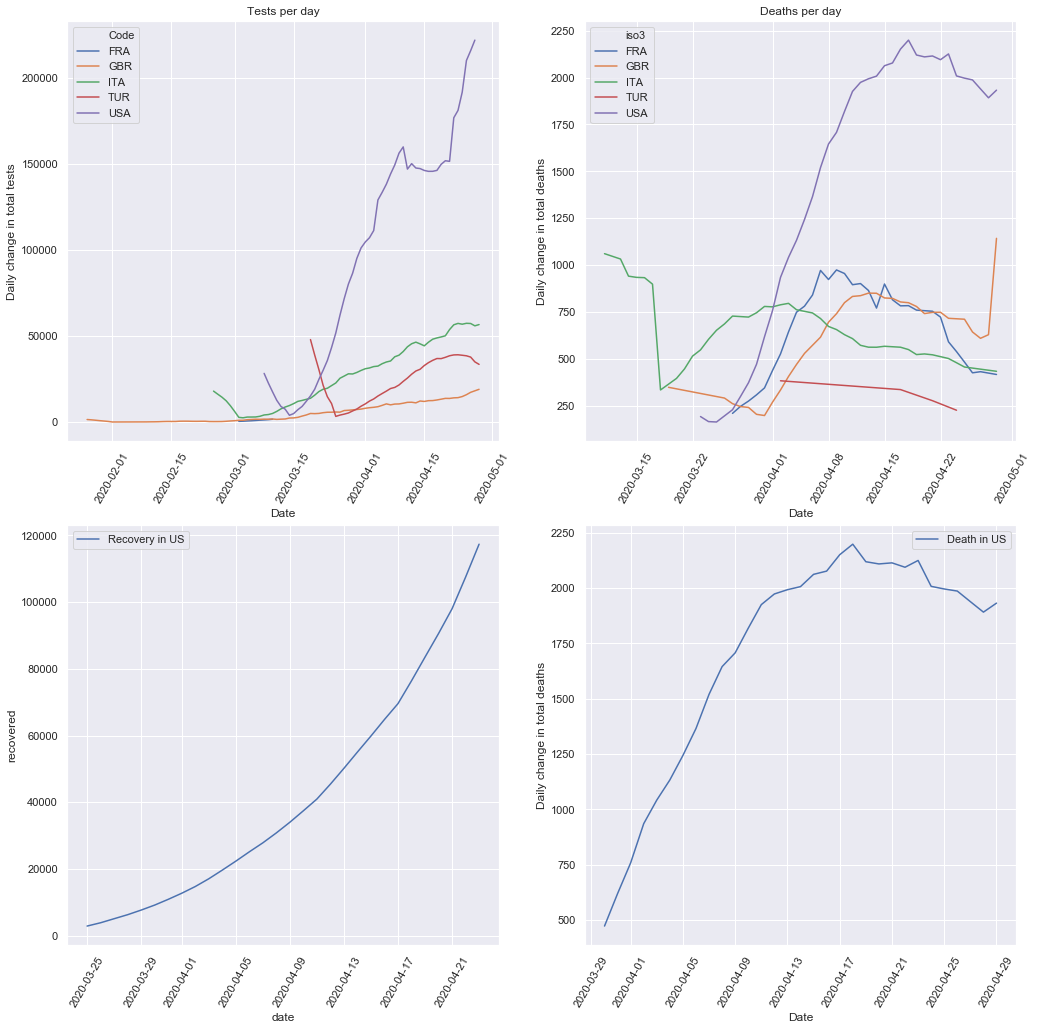

In [348]:
#Read data that has information about the number of tests conducted per day for different countries
tests_per_day = pd.read_csv('Datasets/full-list-covid-19-tests-per-day.csv', index_col='Code', parse_dates=[2])
tests_per_country_per_day = tests_per_day.groupby([tests_per_day.index, 'Date']).sum()
recovery_per_day_US = pd.read_csv('Datasets/daily.csv', index_col='date', parse_dates=True, usecols=['date','recovered'])

#convert the Series computed above to Dataframe
if isinstance(deaths_per_day_per_country_cpy, pd.Series):
    deaths_per_day_per_country_cpy = deaths_per_day_per_country_cpy.to_frame()
    
#Rename the unnamed column
deaths_per_day_per_country_cpy = deaths_per_day_per_country_cpy.rename(columns={"Difference":"Daily change in total deaths"})

#Slice the multindexed data for the top five countries data is found and the US separately
top_countries_test = tests_per_country_per_day.loc[(['USA','FRA', 'ITA', 'GBR', 'TUR'], slice(None)), :]
top_countries_death = deaths_per_day_per_country_cpy.loc[(['USA','FRA', 'ITA', 'GBR', 'TUR'], slice(None)), :]
death_per_day_US = deaths_per_day_per_country_cpy.loc[('USA')]

#reduce the multindex to single index
top_countries_test_dateIndex = top_countries_test.reset_index(level=0)
top_countries_death_dateIndex = top_countries_death.reset_index(level=0)

#Compute the Rolling average for Dailt Deaths, Recoveries and Tests conducted
top_countries_test_rolling = top_countries_test_dateIndex.rolling(window=7).mean()['Daily change in total tests']
top_countries_death_rolling = top_countries_death_dateIndex.rolling(window=7).mean()['Daily change in total deaths']
US_recovery_rolling = recovery_per_day_US.rolling(window=7).mean()['recovered']
US_death_rolling = death_per_day_US.rolling(window=7).mean()['Daily change in total deaths']

#Format and plot the results
fig = plt.figure()
fig.set_figheight(17)
fig.set_figwidth(17)

plt.subplot(221)
plt.title("Tests per day")
sns.lineplot(x=top_countries_test_dateIndex.index, y=top_countries_test_rolling, data=top_countries_test_dateIndex, hue='Code')
plt.xticks(rotation=60)

plt.subplot(222)
plt.title("Deaths per day")
sns.lineplot(x=top_countries_death_dateIndex.index, y=top_countries_death_rolling, data=top_countries_death_dateIndex, hue='iso3')
plt.xticks(rotation=60)

plt.subplot(223)
sns.lineplot(x=recovery_per_day_US.index, y=US_recovery_rolling, label="Recovery in US")
plt.xticks(rotation=60)

plt.subplot(224)
sns.lineplot(x=death_per_day_US.index, y=US_death_rolling, label="Death in US")
plt.xticks(rotation=60)

plt.show()